<a href="https://colab.research.google.com/github/thinhhoUB/Transfer-Learning---Vietnamese-Food-Classification/blob/main/Transfer_Learning_Vietnamese_Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion() 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#directory of data
data_dir = '/content/drive/MyDrive/vietnamesefood'
#data transformation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),#diversity of image data 50% flipping image
        transforms.ToTensor(),
        transforms.Normalize([0.6189, 0.5372, 0.3989], [0.2598, 0.2522, 0.2834])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.6189, 0.5372, 0.3989], [0.2598, 0.2522, 0.2834])
    ]),
}
#loading data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class_names

['bánh bao',
 'bánh mì',
 'bánh tráng trộn',
 'bánh xèo',
 'bún bò huế',
 'bún đậu mắm tôm',
 'cơm tấm',
 'gỏi cuốn',
 'mì quảng',
 'phở bò']

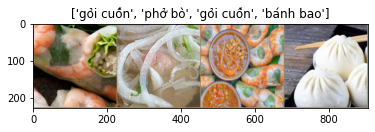

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6189, 0.5372, 0.3989])
    std = np.array([0.2598, 0.2522, 0.2834])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
classes

tensor([7, 9, 7, 0])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()#timing the training

    best_model_wts = copy.deepcopy(model.state_dict())#save the best model after every epochs
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.9416 Acc: 0.3445
val Loss: 1.0769 Acc: 0.6819

Epoch 1/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.3363 Acc: 0.5487
val Loss: 0.7391 Acc: 0.7421

Epoch 2/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.1892 Acc: 0.6269
val Loss: 0.7057 Acc: 0.7736

Epoch 3/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.0761 Acc: 0.6521
val Loss: 0.6537 Acc: 0.7822

Epoch 4/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.1470 Acc: 0.6235
val Loss: 0.5921 Acc: 0.8195

Epoch 5/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.1151 Acc: 0.6479
val Loss: 0.5711 Acc: 0.8052

Epoch 6/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.9866 Acc: 0.6899
val Loss: 0.4724 Acc: 0.8567

Epoch 7/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8796 Acc: 0.7101
val Loss: 0.4884 Acc: 0.8395

Epoch 8/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8373 Acc: 0.7412
val Loss: 0.4182 Acc: 0.8567

Epoch 9/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8596 Acc: 0.7244
val Loss: 0.4255 Acc: 0.8682

Epoch 10/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.9174 Acc: 0.7034
val Loss: 0.4403 Acc: 0.8625

Epoch 11/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8458 Acc: 0.7168
val Loss: 0.4311 Acc: 0.8739

Epoch 12/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8609 Acc: 0.7252
val Loss: 0.4436 Acc: 0.8653

Epoch 13/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8333 Acc: 0.7336
val Loss: 0.4420 Acc: 0.8797

Epoch 14/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8491 Acc: 0.7303
val Loss: 0.4462 Acc: 0.8453

Epoch 15/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8337 Acc: 0.7311
val Loss: 0.4301 Acc: 0.8768

Epoch 16/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8310 Acc: 0.7496
val Loss: 0.4278 Acc: 0.8711

Epoch 17/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8458 Acc: 0.7462
val Loss: 0.4408 Acc: 0.8567

Epoch 18/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8152 Acc: 0.7370
val Loss: 0.4570 Acc: 0.8596

Epoch 19/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8389 Acc: 0.7303
val Loss: 0.4268 Acc: 0.8768

Epoch 20/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8349 Acc: 0.7353
val Loss: 0.4705 Acc: 0.8510

Epoch 21/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8144 Acc: 0.7504
val Loss: 0.4305 Acc: 0.8596

Epoch 22/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8431 Acc: 0.7286
val Loss: 0.4566 Acc: 0.8481

Epoch 23/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8037 Acc: 0.7588
val Loss: 0.4178 Acc: 0.8797

Epoch 24/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8494 Acc: 0.7286
val Loss: 0.4405 Acc: 0.8653

Training complete in 58m 31s
Best val Acc: 0.879656


In [ ]:
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=data_transforms['val'])
test_dataloaders =torch.utils.data.DataLoader(test_datasets, batch_size=4,shuffle=True,num_workers=2)

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

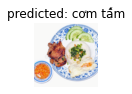

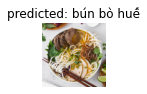

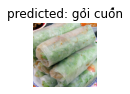

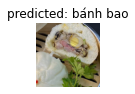

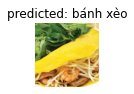

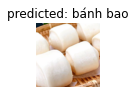

In [ ]:
visualize_model(model_conv)

In [ ]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    n_correct= 0
    n_sample= 0
    for images,labels in test_dataloaders:
        images= images.to(device)
        labels= labels.to(device)
        outputs= model_conv(images)
        #value,index
        _,predictions= torch.max(outputs,1)
        for t, p in zip(labels.view(-1), predictions.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1
        n_sample+= labels.shape[0]
        n_correct+= (predictions==labels).sum().item()
    accuracy= 100*n_correct/n_sample
accuracy

89.31750741839762

In [ ]:
print(confusion_matrix)


tensor([[24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 1., 24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 22.,  0.,  1.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  1.,  0., 20.,  0.,  1.,  2.,  0.,  1.,  0.],
        [ 0.,  1.,  0.,  0., 18.,  0.,  1.,  0.,  1.,  4.],
        [ 0.,  0.,  2.,  0.,  1., 22.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  0.,  1.,  0.,  0., 27.,  0.,  2.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0., 48.,  1.,  2.],
        [ 0.,  0.,  0.,  1.,  1.,  0.,  0.,  0., 42.,  0.],
        [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  3., 54.]])


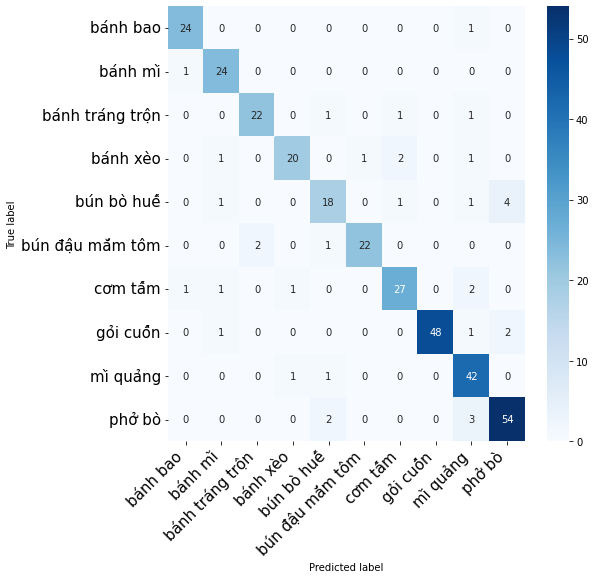

In [ ]:
import seaborn as sns
import pandas as pd
plt.figure(figsize=(8,8))

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap='Blues')

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
torch.save(model_conv.state_dict(), "vietnam_food.pth")